In [1]:
%cd ..

/home/tk/repos/explicit-memory


In [5]:
memory_order = ["episodic", "semantic", "both", "both_presem"]


from utils import read_yaml
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

results_raw = [
    read_yaml(path) for path in tqdm(glob("./training-results/*/results.yaml"))
]

results = {key: [] for key in memory_order}
for result in results_raw:
    if result["memory_type"] == "episodic":
        results["episodic"].append(result)
    elif result["memory_type"] == "semantic":
        results["semantic"].append(result)
    elif result["memory_type"] == "both" and (not result["pretrained_semantic"]):
        results["both"].append(result)
    elif result["memory_type"] == "both" and (result["pretrained_semantic"]):
        results["both_presem"].append(result)
    else:
        raise ValueError

for key, val in results.items():
    print(key, len(val))

for memory_type in memory_order:
    results[memory_type] = sorted(
        results[memory_type],
        key=lambda x: x["capacity"]["episodic"] + x["capacity"]["semantic"],
    )


def select_by_policy(
    results_,
    episodic_forget=None,
    episodic_answer=None,
    semantic_forget=None,
    semantic_answer=None,
):
    if episodic_forget is None and episodic_answer is None:
        results_ = [
            r
            for r in results_
            if r["policy"]["forget"] == semantic_forget
            and r["policy"]["answer"] == semantic_answer
        ]
        return results_
    elif semantic_forget is None and semantic_answer is None:
        results_ = [
            r
            for r in results_
            if r["policy"]["forget"] == episodic_forget
            and r["policy"]["answer"] == episodic_answer
        ]
        return results_
    else:
        results_ = [
            r
            for r in results_
            if r["policy"]["semantic"]["forget"] == semantic_forget
            and r["policy"]["semantic"]["answer"] == semantic_answer
            and r["policy"]["episodic"]["forget"] == episodic_forget
            and r["policy"]["episodic"]["answer"] == episodic_answer
        ]
        return results_

  0%|          | 0/400 [00:00<?, ?it/s]

episodic 40
semantic 40
both 160
both_presem 160


In [32]:
from utils import read_json

dataset_stats = read_json('./data/dataset-stats.json')

reward_max = {}
reward_max['train'] = dataset_stats['num_train_samples']
reward_max['val'] = dataset_stats['num_val_samples']
reward_max['test'] = dataset_stats['num_test_samples']

episodic 10
semantic 10
both 10
both_presem 10



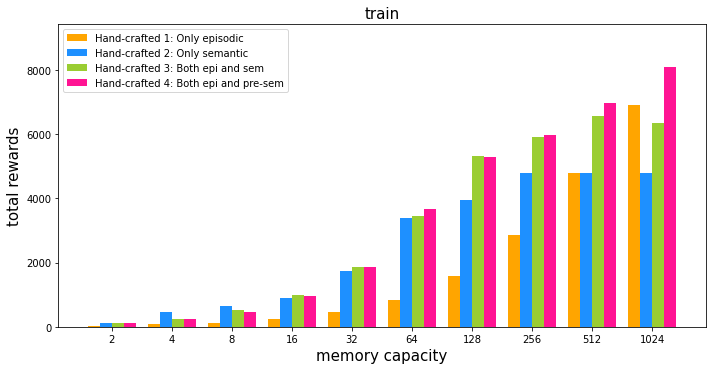

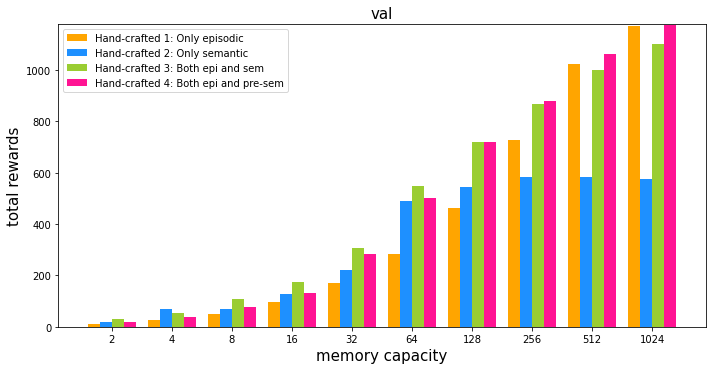

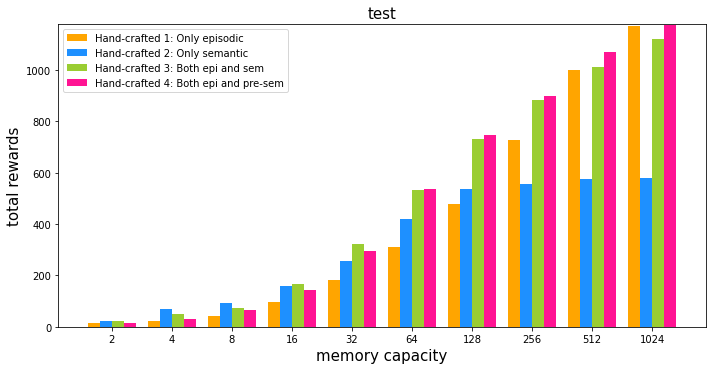

In [40]:
episodic_forget = "oldest"
episodic_answer = "latest"
semantic_forget = "weakest"
semantic_answer = "strongest"

# episodic_forget = "random"
# episodic_answer = "random"
# semantic_forget = "random"
# semantic_answer = "random"

legend_order = [
    "Hand-crafted 1: Only episodic",
    "Hand-crafted 2: Only semantic",
    "Hand-crafted 3: Both epi and sem",
    "Hand-crafted 4: Both epi and pre-sem",
]

color_order = ["orange", "dodgerblue", "yellowgreen", "deeppink"]

results_ = {}


for memory_type in memory_order:
    if memory_type == "episodic":
        results_[memory_type] = select_by_policy(
            results[memory_type], episodic_forget=episodic_forget, episodic_answer=episodic_answer
        )
    elif memory_type == "semantic":
        results_[memory_type] = select_by_policy(
            results[memory_type], semantic_forget=semantic_forget, semantic_answer=semantic_answer
        )
    elif memory_type == "both":
        results_[memory_type] = select_by_policy(
            results[memory_type],
            episodic_forget=episodic_forget,
            episodic_answer=episodic_answer,
            semantic_forget=semantic_forget,
            semantic_answer=semantic_answer,
        )
    elif memory_type == "both_presem":
        results_[memory_type] = select_by_policy(
            results[memory_type],
            episodic_forget=episodic_forget,
            episodic_answer=episodic_answer,
            semantic_forget=semantic_forget,
            semantic_answer=semantic_answer,
        )

for key, val in results_.items():
    print(key, len(val))

print()

for split in ["train", "val", "test"]:
    capacity = [sum(foo["capacity"].values()) for foo in results_["episodic"]]

    data = {
        memory_type: {
            cap: reward
            for cap, reward in zip(
                capacity, [foo[split]["rewards"] for foo in results_[memory_type]]
            )
        }
        for memory_type in memory_order
    }

    fig, ax = plt.subplots(figsize=(10, 5))

    idx = np.asanyarray([i for i in range(len(capacity))])

    width = 0.2

    for memory_type, w, color in zip(memory_order, [-1.5, -0.5, 0.5, 1.5], color_order):
        # print(f"{split}, {memory_type}, max: {max([val for key, val in data[memory_type].items()])}")
        ax.bar(
            idx + w * width,
            [val for key, val in sorted(data[memory_type].items())],
            width=width,
            color=color,
        )

    ax.set_xticks(idx)
    ax.set_xticklabels(capacity)
    ax.legend(legend_order, fontsize=10, loc='upper left')
    ax.set_xlabel("memory capacity", fontsize=15)
    ax.set_ylabel("total rewards", fontsize=15)

    ax.set_ylim([0, reward_max[split]])

    fig.tight_layout()
    plt.title(split, fontsize=15)
    plt.savefig("./figures/" + split + "-bar.png", bbox_inches="tight")
    plt.show()



1172